In [1]:
from GLC23PatchesProviders import MultipleRasterPatchProvider, RasterPatchProvider
from GLC23Datasets import PatchesDataset, PatchesDatasetMultiLabel
from models import cnn

In [2]:
import torch
# from pathlib import Path
# import os
# import rasterio
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score

In [3]:
seed = 42

np.random.seed(seed) # Numpy seed also uses by Scikit Learn
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

In [4]:
data_path = 'data/full_data/'
presence_only_path = data_path+'Presence_only_occurrences/Presences_only_train_sampled.csv'
presence_absence_path = data_path+'Presence_Absence_surveys/Presences_Absences_train.csv'

In [8]:
p_bioclim = MultipleRasterPatchProvider(
    data_path+'EnvironmentalRasters/Climate/BioClimatic_Average_1981-2010/'
) #19
p_hfp_d = MultipleRasterPatchProvider(data_path+'EnvironmentalRasters/HumanFootprint/detailed/') #14
p_hfp_s = RasterPatchProvider(data_path+'EnvironmentalRasters/HumanFootprint/summarized/HFP2009_WGS84.tif') #1

In [70]:
# PRESENCE ONLY DATA
presence_only_df = pd.read_csv(presence_only_path, sep=";", header='infer', low_memory=False)
# split presence only dataset into train and validation sets
train_df, val_df = train_test_split(presence_only_df, test_size=0.2)

# train dataset
train_data = PatchesDatasetMultiLabel(
    occurrences=train_df.reset_index(), 
    providers=(p_bioclim, p_hfp_d, p_hfp_s)
)
print(f"\nTRAINING DATA: n={len(train_data)}")

# get number of features and number of species in train dataset
n_features = train_data[0][0].cpu().detach().shape[0]
print(f"Number of covariates = {n_features}")
n_species = len(train_data.unique_sorted_targets)
print(f"Number of species = {n_species}")

# validation dataset
val_data = PatchesDatasetMultiLabel(
    occurrences=val_df.reset_index(), 
    providers=(p_bioclim, p_hfp_d, p_hfp_s),
    ref_targets=train_data.unique_sorted_targets
)
print(f"VALIDATION DATA: n={len(val_data)}")


TRAINING DATA: n=2131709
Number of covariates = 34
Number of species = 9659
VALIDATION DATA: n=532928


In [10]:
# PRESENCE ABSENCE DATA 
presence_absence_df = pd.read_csv(presence_absence_path, sep=";", header='infer', low_memory=False)
test_data = PatchesDatasetMultiLabel(
    occurrences=presence_absence_df, 
    providers=(p_bioclim, p_hfp_d, p_hfp_s),
    ref_targets=train_data.unique_sorted_targets
)
print(f"TEST DATA: n={len(test_data)}")

TEST DATA: n=85325


In [34]:
model = cnn(n_features, n_species)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

checkpoint = torch.load("models/2504_1700_full_data_sampled/best.pth")
model.load_state_dict(checkpoint['state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
loss = checkpoint['loss']
model

cnn(
  (conv1): Conv2d(34, 32, kernel_size=(3, 3), stride=(1, 1))
  (act1): ReLU()
  (pool1): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (drop1): Dropout(p=0.3, inplace=False)
  (conv2): Conv2d(32, 8, kernel_size=(3, 3), stride=(1, 1))
  (act2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flat): Flatten(start_dim=1, end_dim=-1)
  (fc4): Linear(in_features=3200, out_features=9659, bias=True)
  (act4): ReLU()
)

In [15]:
batch_size = 100
val_loader = torch.utils.data.DataLoader(val_data, shuffle=False, batch_size=batch_size, num_workers=4)

In [65]:
for inputs, labels in val_loader:
    print(labels.shape)
    break

torch.Size([100, 9660])


In [66]:
y_pred = model(inputs)

In [67]:
y_pred.shape

torch.Size([100, 9659])

In [43]:
y_pred = y_pred.detach().numpy()
y_true = labels#.().numpy()
species_idx = np.where(y_true.sum(axis=0) != 0)[0]
len(species_idx)

110

In [64]:
for i in range(y_pred.shape[0]):
    print(i, f1_score(y_true[i, :], y_pred[i, :]))
    break

ValueError: Found input variables with inconsistent numbers of samples: [9660, 9659]

In [62]:
auc_rocs = f1_score(y_true[:,species_idx], y_pred[:,species_idx], average=None)
auc_rocs

ValueError: Classification metrics can't handle a mix of multilabel-indicator and continuous-multioutput targets

In [59]:
y_true[0,species_idx]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.], dtype=torch.float64)

In [60]:
y_pred[0,species_idx]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [ ]:
model.eval()
        avg_aucs = []
        for inputs, labels in val_loader:
            inputs = inputs.to(dev)
            labels = labels.to(dev)
            y_pred = model(inputs)
            # validation loss
            val_loss = loss_fn(y_pred, labels).cpu().detach()
            # validation AUC
            y_pred = y_pred.cpu().detach().numpy()
            y_true = labels.cpu().detach().numpy()
            species_idx = np.where(y_true.sum(axis=0) != 0)[0]
            auc_rocs = roc_auc_score(y_true[:,species_idx], y_pred[:,species_idx], average=None)
            avg_aucs.append(auc_rocs.mean())
        # average AUC 
        avg_auc = np.array(avg_aucs).mean() # this is not great
        print(f"{epoch}) AVG_AUC={avg_auc} (for {len(species_idx)} species)")

        # log train and val metrics for epoch
        wandb.log({"train_loss": train_loss, "val_loss": val_loss, "val_avg_auc": avg_auc})
        if epoch == 0: wandb.config['n_species_val'] = len(species_idx)
    
    model.eval()
    avg_aucs = []
    for inputs, labels in test_loader:
        inputs = inputs.to(dev)
        labels = labels.to(dev)
        y_pred = model(inputs)
        # test loss
        test_loss = loss_fn(y_pred, labels).cpu().detach()
        # test AUC
        y_pred = y_pred.cpu().detach().numpy()
        y_true = labels.cpu().detach().numpy()
        species_idx = np.where(y_true.sum(axis=0) != 0)[0]
        auc_rocs = roc_auc_score(y_true[:,species_idx], y_pred[:,species_idx], average=None)
        avg_aucs.append(auc_rocs.mean())

    avg_auc = np.array(avg_aucs).mean()
    print(f"TEST SET: AVG_AUC={avg_auc} (for {len(species_idx)} species)")

    wandb.log({"test_loss": test_loss, "test_avg_auc": avg_auc})
    wandb.config["n_species_test"] = len(species_idx)
        

In [5]:
df = pd.read_csv(presence_only_path, sep=';', index_col=0)
df

,glcID,gbifID,observer,datasetName,date,dayOfYear,year,lon,lat,x_EPSG3035,y_EPSG3035,geoUncertaintyInM,speciesId,patchID,timeSerieID
6,4678868,3.957154e+09,NaN,Pl@ntNet automatic,2021-07-27,208,2021,-10.467350,52.13646,2940930.0,3421109.0,8.00,5020,3018875,1006
7,1797028,3.952319e+09,NaN,Pl@ntNet automatic,2019-07-29,210,2019,-10.466490,52.14950,2941391.0,3422495.0,24.00,5020,3018876,1007
9,1768174,3.955862e+09,NaN,Pl@ntNet automatic,2021-08-27,239,2021,-10.466180,52.14698,2941333.0,3422218.0,21.00,5020,3018878,1009
34,304112,3.953985e+09,NaN,Pl@ntNet automatic,2019-07-28,209,2019,-10.404300,51.89073,2937454.0,3393477.0,24.00,5020,3018903,1034
42,1751578,3.951651e+09,NaN,Pl@ntNet automatic,2019-06-17,168,2019,-10.372510,52.12839,2946879.0,3418438.0,13.94,8455,3018911,1042
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1702364,2768427,3.949402e+09,NaN,Pl@ntNet observations,2020-10-25,299,2020,5.545360,43.54632,3960316.0,2281554.0,35.87,10039,4650279,1627732
1359237,394413,2.235343e+09,NaN,Waarnemingen.be,2017-11-06,310,2017,4.305540,51.33708,3924628.0,3151702.0,10.00,10039,4323620,1301909
2578717,3731130,3.330533e+09,Pedro Hafermann,iNaturalist RG,2021-06-11,162,2021,8.686638,50.59022,4227997.0,3053992.0,81.00,10039,5387693,2363180
414913,3957489,3.113401e+09,lindae2,iNaturalist RG,2021-05-10,130,2021,-2.101907,53.32616,3518906.0,3424704.0,10.00,10039,3410382,392774


In [71]:
from sklearn.model_selection import train_test_split
train_data, val_data = train_test_split(df, test_size=0.2)

In [66]:
df[df.speciesId == 4933].shape[0] / df.shape[0] * 100

0.08533995437277198

In [65]:
train_data[train_data.speciesId == 4933].shape[0] / train_data.shape[0] * 100

0.08753540000065675

In [64]:
val_data[val_data.speciesId == 4933].shape[0] / val_data.shape[0] * 100

0.07655818422000721

In [54]:
train_data

,glcID,gbifID,observer,datasetName,date,dayOfYear,year,lon,lat,x_EPSG3035,y_EPSG3035,geoUncertaintyInM,speciesId,patchID,timeSerieID
717044,4007066,2.645766e+09,NaN,Pl@ntNet automatic,2019-06-25,176,2019,-0.046204,45.80299,3541687.0,2573834.0,48.0,6060,3694919,677092
3861688,3863996,2.896479e+09,Odsherred Kommune,DEN Environmental Portal,2019-06-05,156,2019,11.585070,55.89640,4420217.0,3644678.0,3.0,4933,6171791,3149335
2716925,567866,3.383967e+09,jam63,iNaturalist RG,2021-09-03,246,2021,9.022240,50.13429,4251090.0,3002912.0,4.0,6572,5476141,2451820
2106944,3218638,3.949017e+09,NaN,Pl@ntNet observations,2020-06-30,182,2020,6.988320,51.38851,4111426.0,3146286.0,58.1,9785,5022227,1997945
4713689,3207370,2.977045e+09,NaN,Pl@ntNet automatic,2020-05-02,123,2020,18.031350,48.65135,4911631.0,2869769.0,5.0,6700,6828098,3807592
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2545784,2762096,2.848818e+09,Sverre Lundemo,NOR Species Observation,2020-08-15,228,2020,8.603651,61.48437,4246337.0,4265562.0,10.0,6498,5363807,2339262
4540985,3981383,3.949191e+09,NaN,Pl@ntNet observations,2021-06-05,156,2021,15.787500,50.02424,4735282.0,3006555.0,19.0,3204,6688898,3667918
2026546,2982709,3.952768e+09,NaN,Pl@ntNet automatic,2021-08-05,217,2021,6.712116,45.49092,4063696.0,2492179.0,24.0,9224,4948285,1924500
3140779,2128452,2.410691e+09,Kåre Arnstein Lye,NOR Species Observation,2017-05-13,133,2017,9.910771,59.06790,4315871.0,3996341.0,20.0,7896,5699296,2675408


In [55]:
val_data

,glcID,gbifID,observer,datasetName,date,dayOfYear,year,lon,lat,x_EPSG3035,y_EPSG3035,geoUncertaintyInM,speciesId,patchID,timeSerieID
1805820,2525253,3.953278e+09,NaN,Pl@ntNet automatic,2018-10-22,295,2018,5.918048,43.07270,3987778.0,2227420.0,3.49,7760,4744170,1721040
2230817,1619320,3.958882e+09,NaN,Pl@ntNet automatic,2021-06-01,152,2021,7.459309,48.45155,4133026.0,2818580.0,65.00,3007,5133600,2108632
1256722,474598,3.955544e+09,NaN,Pl@ntNet automatic,2021-05-18,138,2021,3.750968,47.46593,3850184.0,2725700.0,12.00,2132,4221848,1201432
3601085,2406287,1.882959e+09,Bjørn Petter Løfall,NOR Species Observation,2018-05-16,136,2018,10.933670,59.05363,4374687.0,3995103.0,10.00,988,5974684,2951967
4813758,2048151,3.325788e+09,laippo,iNaturalist RG,2021-07-05,186,2021,22.301160,60.45409,4995920.0,4209221.0,5.00,1573,6914594,3894323
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3073673,2062579,2.991547e+09,Favrskov Kommune,DEN Environmental Portal,2020-08-21,234,2020,9.797880,56.37459,4308501.0,3696808.0,3.00,7054,5667350,2643385
2968239,2144555,3.414282e+09,Silkeborg Kommune,DEN Environmental Portal,2021-07-02,183,2021,9.608002,56.17557,4296635.0,3674713.0,27.84,7378,5613781,2589724
1138971,3279099,3.951615e+09,NaN,Pl@ntNet automatic,2018-06-24,175,2018,3.044954,44.65896,3769224.0,2419894.0,10.00,6912,4106280,1087251
3774144,1283725,3.303425e+09,Bjørn Petter Løfall,NOR Species Observation,2021-05-15,135,2021,11.369500,59.16099,4399503.0,4007442.0,4.00,2225,6103857,3081330


<AxesSubplot: >

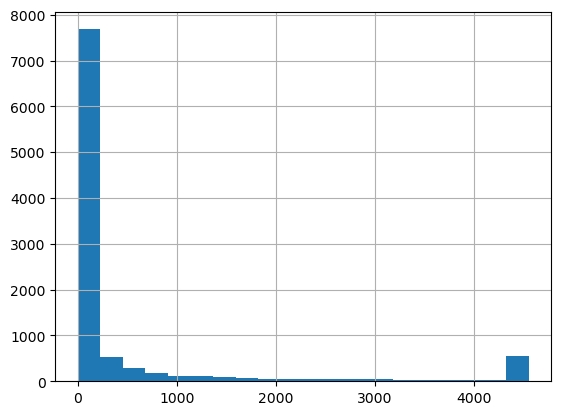

In [31]:
species_counts = df.groupby('speciesId').glcID.count().sort_values()
species_counts.hist(bins=20)

In [39]:
df_sample = df.groupby('speciesId', group_keys=False).apply(lambda x: x.sample(frac=0.3))
df_sample

,glcID,gbifID,observer,datasetName,date,dayOfYear,year,lon,lat,x_EPSG3035,y_EPSG3035,geoUncertaintyInM,speciesId,patchID,timeSerieID
612411,267186,3.959115e+09,NaN,Pl@ntNet automatic,2021-08-11,223,2021,-0.705068,48.05901,3525832.0,2829481.0,9.21,1,3596421,578766
201916,3594188,3.952660e+09,NaN,Pl@ntNet automatic,2021-02-28,59,2021,-3.776326,40.22430,3149788.0,2009946.0,65.00,1,3214820,197064
2128125,3220719,3.959983e+09,NaN,Pl@ntNet automatic,2021-05-12,132,2021,7.052574,52.46008,4120718.0,3265250.0,16.00,1,5041355,2016945
3710831,3288959,3.949441e+09,NaN,Pl@ntNet observations,2021-03-26,85,2021,11.208920,48.18080,4410939.0,2785987.0,3.86,1,6057115,3034512
282214,456664,3.902650e+09,Steven Cross,iNaturalist RG,2021-05-01,121,2021,-3.017264,53.47863,3462037.0,3451954.0,5.00,1,3290593,272797
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3043593,1825529,3.097104e+09,Giovanni Perico,iNaturalist RG,2021-04-20,110,2021,9.742413,45.62340,4300883.0,2501242.0,31.00,10039,5652210,2628219
1159125,488467,2.235343e+09,NaN,Waarnemingen.be,2017-09-16,259,2017,3.133670,51.02888,3840107.0,3124556.0,10.00,10039,4126600,1106964
2289183,2947424,3.953960e+09,NaN,Pl@ntNet automatic,2020-12-15,350,2020,7.691809,45.65934,4140885.0,2507986.0,64.00,10039,5186826,2161922
3994728,1982971,2.974516e+09,NaN,Pl@ntNet observations,2020-05-03,124,2020,12.036100,44.20674,4484070.0,2346271.0,9.00,10039,6261160,3238796


In [41]:
from sklearn.model_selection import train_test_split
train_data, val_data = train_test_split(df_sample, test_size=0.2)

In [42]:
train_data.shape

(1177884, 15)

In [44]:
val_data

,glcID,gbifID,observer,datasetName,date,dayOfYear,year,lon,lat,x_EPSG3035,y_EPSG3035,geoUncertaintyInM,speciesId,patchID,timeSerieID
1501153,1859929,3.955971e+09,NaN,Pl@ntNet automatic,2019-06-13,164,2019,4.787549,52.65130,3968577.0,3295109.0,24.0,3465,4462951,1441286
3532769,3675503,2.237249e+09,Odd Egil Stabbetorp,NOR Species Observation,2019-04-17,107,2019,10.773720,59.39463,4365057.0,4032897.0,6.0,8183,5924528,2901723
4904248,312285,1.822742e+09,Geir Arne Evje;Asle Bruserud;Bård Haugsrud;Øys...,NOR Species Observation,2017-07-15,196,2017,29.624340,69.97092,5068614.0,5311805.0,25.0,9802,6997481,3977275
2921814,2442943,2.896007e+09,Miljøstyrelsen,DEN Environmental Portal,2018-08-07,219,2018,9.510967,57.18834,4291398.0,3787419.0,3.0,2226,5590231,2566130
1766895,3727593,2.397448e+09,NaN,Waarnemingen.be,2019-08-08,220,2019,5.767520,51.01377,4024163.0,3108867.0,25.0,3412,4707099,1683985
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3212501,3385,2.978721e+09,Odder Kommune,DEN Environmental Portal,2020-06-16,168,2020,10.039960,55.85253,4323504.0,3638704.0,3.0,8424,5734518,2710678
4440452,1902677,3.954973e+09,NaN,Pl@ntNet automatic,2021-04-06,96,2021,15.041410,40.19806,4752090.0,1914658.0,8.0,1038,6623657,3602050
481465,182148,3.352685e+09,"Eaton, M. Mark",iRecord verified,2019-07-01,182,2019,-1.632443,55.43216,3587962.0,3651310.0,5.0,3116,3472666,455046
3192582,4529499,3.957809e+09,NaN,Pl@ntNet automatic,2020-07-12,194,2020,10.001200,50.94106,4321084.0,3092186.0,9.5,8820,5723901,2700044


<AxesSubplot: >

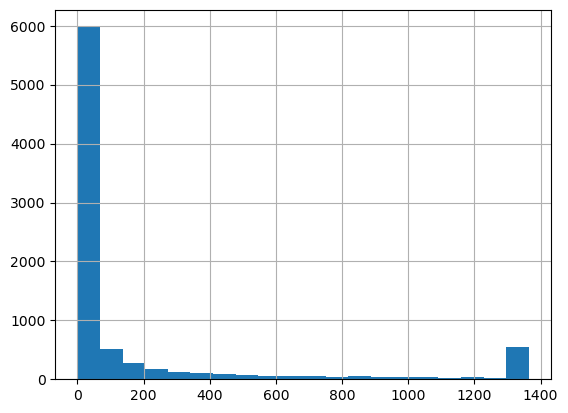

In [40]:
df_sample.groupby('speciesId').glcID.count().sort_values().hist(bins=20)

In [7]:
df.groupby('speciesId', group_keys=False).apply(lambda x: x.sample(100))

ValueError: Cannot take a larger sample than population when 'replace=False'

In [35]:
thresh = 500
frac = 0.5
df_no_sample = df[df['speciesId'].isin(species_counts[species_counts <= thresh].index)]
df_sample = df[df['speciesId'].isin(species_counts[species_counts > thresh].index)].groupby(
    'speciesId', group_keys=False).apply(lambda x: x.sample(frac=frac))
df_sampled = pd.concat([df_no_sample, df_sample])
df_sampled.shape

(2821747, 15)

<AxesSubplot: >

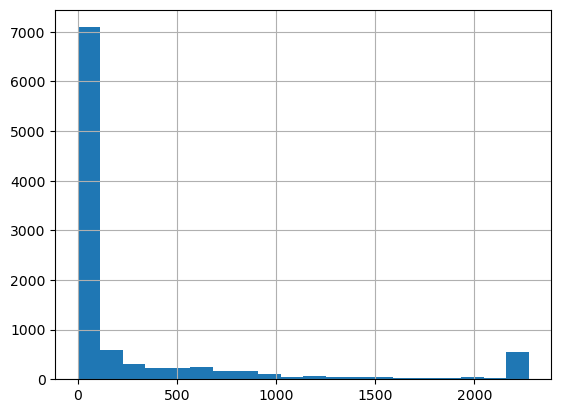

In [36]:
species_counts = df_sampled.groupby('speciesId').glcID.count().sort_values()
species_counts.hist(bins=20)

In [37]:
df_sampled.to_csv(data_path+'Presence_only_occurrences/Presences_only_train_sampled.csv', sep=';')

In [25]:
keep_100 = 
#keep_100
df_keep_100 = 
df_keep_100.shape

(4804620, 15)

In [30]:
df_sampled = 
df_sampled.shape

(2402328, 15)

In [29]:
df_sampled.groupby('speciesId').glcID.count().sort_values()

speciesId
1        100
5        100
10       100
11       100
12       100
        ... 
10025    100
10028    100
10034    100
10035    100
10039    100
Name: glcID, Length: 3072, dtype: int64

In [ ]:

p_hfp_s = RasterPatchProvider(data_path+'EnvironmentalRasters/HumanFootprint/summarized/HFP2009_WGS84.tif') 
p_bioclim = MultipleRasterPatchProvider(data_path+'EnvironmentalRasters/Climate/BioClimatic_Average_1981-2010/')

In [4]:
presence_only = PatchesDatasetMultiLabel(
    occurrences=presence_only_path,
    providers=(p_bioclim, p_hfp_s)
)

In [8]:
len(presence_only.unique_sorted_targets)

10038

In [6]:
presence_absence = PatchesDatasetMultiLabel(
        occurrences=presence_absence_path, 
        providers=(p_bioclim, p_hfp_s),
        ref_targets=presence_only.unique_sorted_targets
)

In [32]:
presence_absence.unique_sorted_targets[9040:9050]

array([9041, 9042, 9043, 9044, 9045, 9046, 9048, 9049, 9050, 9051])

In [16]:
df = pd.read_csv(presence_absence_path, sep=';')

In [17]:
df.iloc[0]

glcID                                 5140269
gbifID                           3473384501.0
observer                                (IGN)
datasetName          Inventaire forestier IGN
date                               2018-01-31
dayOfYear                                  31
year                                     2018
lon                                   7.30079
lat                                  48.29273
x_EPSG3035                          4120673.0
y_EPSG3035                          2801353.0
geoUncertaintyInM                         1.0
speciesId                                6574
patchID                               3018575
timeSerieID                           3980325
Name: 0, dtype: object

In [18]:
np.where(presence_absence[0][1] == 1)

(array([1282, 5313, 6573, 6945, 8078, 8986, 9010, 9328]),)

In [20]:
presence_absence.unique_sorted_targets[np.where(presence_absence[0][1] == 1)]

array([1283, 5314, 6574, 6946, 8079, 8987, 9011, 9330])

In [ ]:
presence

In [16]:
occurrences = Path(presence_only_path)
providers = (p_hfp_s, p_bioclim) 
transform=None
target_transform=None
id_name="glcID"
label_name="speciesId"
item_columns=['lat', 'lon', 'patchID']
device="cpu"
provider = MetaPatchProvider(providers, transform)

In [17]:
df = pd.read_csv(occurrences, sep=";", header='infer', low_memory=False)
observation_ids = df[id_name].values
items = df[item_columns]
targets = df[label_name].values #speciesId

unique_items = items.drop_duplicates()
unique_sorted_targets = np.unique(np.sort(targets))

In [19]:
print(targets.shape, unique_sorted_targets.shape)
print(items.shape, unique_items.shape)

(100,) (96,)
(100, 3) (100, 3)


In [29]:
df.iloc[0]

glcID                                       2522017
gbifID                                 1882956579.0
observer                        Bjørn Petter Løfall
datasetName                 NOR Species Observation
date                                     2018-06-17
dayOfYear                                       168
year                                           2018
year_ecodatacube_quarter                        2.0
lon                                        10.95154
lat                                         59.2511
x_EPSG3035                                4375406.0
y_EPSG3035                                4017067.0
geoUncertaintyInM                              10.0
speciesId                                      9343
patchID                                     5982155
timeSerieID                                 2959445
Name: 0, dtype: object

In [30]:
#print(f"PatchesDatasetMultiLabel __getitem__ index={index}")
index = 0
item = items.iloc[index].to_dict()
item

{'lat': 59.2511, 'lon': 10.95154, 'patchID': 5982155.0}

In [32]:
patchid_rows_i = items[items['patchID']==item['patchID']].index
patchid_rows_i

Int64Index([0], dtype='int64')

In [34]:
patch = provider[item]
patch.shape

(4, 128, 128)

In [35]:
item_targets = np.zeros(len(unique_sorted_targets))
for idx in patchid_rows_i:
    target = targets[idx]
    if target_transform:
        target = target_transform(target)
    print(target)
    item_targets[np.where(unique_sorted_targets==target)] = 1
item_targets

9343


array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [37]:
unique_sorted_targets[item_targets == 1]

array([9343])

In [21]:

        
        item_targets = np.zeros(len(self.unique_sorted_targets))
        for idx in patchid_rows_i:
            target = self.targets[idx]
            if self.target_transform:
                target = self.target_transform(target)
            item_targets[np.where(self.unique_sorted_targets==target)] = 1

        print(index, len(item_targets), item_targets.sum(), item_targets[np.where(item_targets!=0)])
        item_targets = torch.from_numpy(item_targets).to(self.device)

        return torch.from_numpy(patch).float().to(self.device), item_targets

Int64Index([0], dtype='int64')

In [22]:
unique_sorted_targets

array([  24,  216,  232,  254,  285,  435,  518,  644,  784,  801,  830,
       1108, 1131, 1503, 1576, 1580, 1706, 1729, 1894, 1954, 2165, 2730,
       2752, 2828, 2963, 2989, 3271, 3349, 3384, 3659, 3674, 3704, 3852,
       3892, 3911, 3943, 4013, 4051, 4102, 4143, 4318, 4634, 4835, 4866,
       5000, 5072, 5154, 5233, 5448, 5767, 5773, 5776, 5868, 6026, 6249,
       6461, 6523, 6705, 6826, 7021, 7193, 7246, 7287, 7449, 7583, 7722,
       7740, 7746, 7747, 7826, 7858, 7904, 8058, 8106, 8126, 8144, 8308,
       8367, 8395, 8456, 8487, 8504, 8820, 8987, 9120, 9343, 9509, 9540,
       9558, 9607, 9669, 9675, 9739, 9753, 9785, 9826])

In [23]:
patch = provider[item]
patch.shape

(4, 128, 128)

In [25]:
item_targets = np.zeros(len(unique_sorted_targets))
item_targets.sum()

0.0

In [27]:
for idx in patchid_rows_i:
    target = targets[idx]
    print(idx, target)
    item_targets[np.where(unique_sorted_targets==target)] = 1

print(item_targets)

0 9343
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [ ]:

        for idx in patchid_rows_i:
            target = self.targets[idx]
            if self.target_transform:
                target = self.target_transform(target)
            targets[np.where(self.targets_sorted==target)] = 1

        print(index, len(targets), targets.sum(), targets[np.where(targets!=0)])
        targets = torch.from_numpy(targets).to(self.device)

        return torch.from_numpy(patch).float().to(self.device), targets

In [37]:
patch = provider[item]
patch.shape

MetaPatchProvider __getitem__ item={'lat': 59.2511, 'lon': 10.95154, 'patchID': 5982155.0}
RasterPatchProvider __getitem__ item={'lat': 59.2511, 'lon': 10.95154, 'patchID': 5982155.0}
RasterPatchProvider __getitem__ item={'lat': 59.2511, 'lon': 10.95154, 'patchID': 5982155.0}
RasterPatchProvider __getitem__ item={'lat': 59.2511, 'lon': 10.95154, 'patchID': 5982155.0}
RasterPatchProvider __getitem__ item={'lat': 59.2511, 'lon': 10.95154, 'patchID': 5982155.0}


(4, 128, 128)

In [48]:
targets_vec = np.zeros(len(targets))
targets_vec

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [51]:
targets_vec[np.where(targets_vec!=0)]

array([1.])

In [49]:
idx=0
target = targets[idx]
target

9343

In [50]:
targets_vec[np.where(targets_sorted==target)] = 1
targets_vec

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [ ]:

        
        for idx in patchid_rows_i:
            target = self.targets[idx]
            if self.target_transform:
                target = self.target_transform(target)
            
        targets = torch.from_numpy(targets).to(self.device)

In [ ]:

class PatchesDataset(Dataset):
    def __init__(
        self,
        occurrences,
        providers,
        transform=None,
        target_transform=None,
        id_name="glcID",
        label_name="speciesId",
        item_columns=['lat', 'lon', 'patchID'],
        device="cpu"
    ):
        #print("PatchesDataset __init__")
        self.occurences = Path(occurrences)
        self.base_providers = providers
        self.transform = transform
        self.target_transform = target_transform
        self.provider = MetaPatchProvider(self.base_providers, self.transform)
        self.device = device

        df = pd.read_csv(self.occurences, sep=";", header='infer', low_memory=False)

        self.observation_ids = df[id_name].values
        self.items = df[item_columns]
        self.targets = df[label_name].values

    def __len__(self):
        #print("PatchesDataset __init__")
        return len(self.observation_ids)

    def __getitem__(self, index):
        #print(f"PatchesDataset __getitem__ index={index}")

        item = self.items.iloc[index].to_dict()
        patch = self.provider[item]
        target = self.targets[index]

        if self.target_transform:
            target = self.target_transform(target)

        return torch.from_numpy(patch).float().to(self.device), target
    
    def plot_patch(self, index):
        item = self.items.iloc[index].to_dict()
        self.provider.plot_patch(item)


class PatchesDatasetMultiLabel(PatchesDataset):
    def __init__(self,
        occurrences,
        providers,
        transform=None,
        target_transform=None,
        id_name="glcID",
        label_name="speciesId",
        item_columns=['lat', 'lon', 'patchID'],
        device="cpu"
    ):
        #print("PatchesDatasetMultiLabel __init__")
        super().__init__(occurrences, providers, transform, target_transform, id_name, label_name, item_columns, device)
        
    def __getitem__(self, index):
        #print(f"PatchesDatasetMultiLabel __getitem__ index={index}")
        item = self.items.iloc[index].to_dict()
        patchid_rows_i = self.items[self.items['patchID']==item['patchID']].index
        self.targets_sorted = np.sort(self.targets)

        patch = self.provider[item]
        targets = np.zeros(len(self.targets))
        for idx in patchid_rows_i:
            target = self.targets[idx]
            if self.target_transform:
                target = self.target_transform(target)
            targets[np.where(self.targets_sorted==target)] = 1
        targets = torch.from_numpy(targets).to(self.device)

        return torch.from_numpy(patch).float().to(self.device), targets

In [3]:
dev = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(dev)

cuda:0


In [35]:
data_path = 'data/full_data/'
presence_only_path = data_path+'Presence_only_occurrences/Presences_only_train.csv'
p_hfp_s = RasterPatchProvider(data_path+'EnvironmentalRasters/HumanFootprint/summarized/HFP2009_WGS84.tif') # take the human footprint 2009 summurized raster
#presence_only = PatchesDatasetMultiLabel(occurrences=presence_only_path, providers=(p_hfp_s), device=dev)


---- RasterPatchProvider __init__


In [36]:
#PatchesDatasetMultiLabel __init__
occurrences = presence_only_path
occurrences = Path(occurrences)
providers = (p_hfp_s)
device = dev
transform=None
target_transform=None,
id_name="glcID",
label_name="speciesId"
item_columns=['lat', 'lon', 'patchID']
#PatchesDataset __init__
#self.provider = MetaPatchProvider(self.base_providers, self.transform)
df = pd.read_csv(occurrences, sep=";", header='infer', low_memory=False)
df

,glcID,gbifID,observer,datasetName,date,dayOfYear,year,lon,lat,x_EPSG3035,y_EPSG3035,geoUncertaintyInM,speciesId,patchID,timeSerieID
0,2774863,1.978418e+09,Jim Kingdon,iNaturalist RG,2018-09-29,272,2018,-10.53904,51.77186,2924908.0,3383275.0,4.0,8075,3018869,1000
1,1043549,2.397517e+09,Julie Hall,iNaturalist RG,2019-08-22,234,2019,-10.53875,51.77226,2924939.0,3383313.0,5.0,8075,3018870,1001
2,3104839,3.953467e+09,NaN,Pl@ntNet automatic,2019-07-10,191,2019,-10.47597,52.11013,2939549.0,3418442.0,5.0,6477,3018871,1002
3,1800638,2.294436e+09,gsauce,iNaturalist RG,2019-07-02,183,2019,-10.47555,52.15074,2940838.0,3422801.0,6.0,5783,3018872,1003
4,4873519,2.265857e+09,guillaumevigneault,iNaturalist RG,2019-06-07,158,2019,-10.47497,52.10978,2939604.0,3418385.0,30.0,9011,3018873,1004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4908314,2889852,3.892391e+09,Alenka Mihoric,iNaturalist RG,2018-05-09,129,2018,34.54567,35.64241,6523828.0,1753690.0,21.0,148,7000525,3980319
4908315,1261849,3.355773e+09,Alenka Mihoric,iNaturalist RG,2018-05-09,129,2018,34.54568,35.64243,6523828.0,1753692.0,38.0,625,7000526,3980320
4908316,844504,2.841228e+09,NaN,Observation.org,2019-01-24,24,2019,34.55360,35.64514,6524428.0,1754209.0,10.0,1088,7000527,3980321
4908317,346527,2.842044e+09,NaN,Observation.org,2019-01-24,24,2019,34.55388,35.64499,6524457.0,1754201.0,10.0,982,7000528,3980322


In [37]:
observation_ids = df.loc[:,id_name].values
items = df[item_columns]
targets = df[label_name].values

In [42]:
#self.nb_layers = sum([len(provider) for provider in self.providers])
provider = providers[0]
provider

---- RasterPatchProvider __getitem__ 0
> /home/nina/Documents/GeoLifeCLEF/GLC23PatchesProviders.py(158)__getitem__()
    156         self.epsg = self.crs.to_epsg()
    157         if self.epsg != 4326:
--> 158             # create a pyproj transformer object to convert lat, lon to EPSG:32738
    159             self.transformer = pyproj.Transformer.from_crs("epsg:4326", self.epsg, always_xy=True)
    160 



In [39]:
providers[0]

---- RasterPatchProvider __getitem__ 0
> /home/nina/Documents/GeoLifeCLEF/GLC23PatchesProviders.py(158)__getitem__()
    156         self.epsg = self.crs.to_epsg()
    157         if self.epsg != 4326:
--> 158             # create a pyproj transformer object to convert lat, lon to EPSG:32738
    159             self.transformer = pyproj.Transformer.from_crs("epsg:4326", self.epsg, always_xy=True)
    160 

--KeyboardInterrupt--

KeyboardInterrupt: Interrupted by user


TypeError: 'int' object is not subscriptable

In [ ]:
#MetaPatchProvider __init__
#nb_layers = sum([len(provider) for provider in providers])
#---- RasterPatchProvider __getitem__ 0





In [ ]:
def __getitem__(self, item):
        print(f"RasterPatchProvider __getitem__ item={item}")
        import pdb; pdb.set_trace()

        """
        :param item: dictionary that needs to contains at least the keys latitude and longitude ({'lat': lat, 'lon':lon})
        :return: return the environmental tensor or vector (size>1 or size=1)
        """
        # convert the lat, lon coordinates to EPSG:32738
        if self.transformer:
            lon, lat = self.transformer.transform(item['lon'], item['lat'])
        else:
            lon, lat = (item['lon'], item['lat'])

        # add noise as data augmentation
        if self.spatial_noise > 0:
            lon = lon + ((random()*2*self.spatial_noise)-self.spatial_noise)
            lat = lat + ((random()*2*self.spatial_noise)-self.spatial_noise)

        # calculate the x, y coordinate of the point of interest
        x = int(self.n_rows - (lat - self.y_min) / self.y_resolution)
        y = int((lon - self.x_min) / self.x_resolution)

        # read the data of the patch from all layers
        if self.patch_size == 1:
            patch_data = [self.data[i, x, y] for i in range(self.nb_layers)]
        else:
            patch_data = [self.data[i, x - (self.patch_size // 2): x + (self.patch_size // 2), y - (self.patch_size // 2): y + (self.patch_size // 2)] for i in range(self.nb_layers)]
        
        tensor = np.concatenate([patch[np.newaxis] for patch in patch_data])
        if self.fill_zero_if_error and tensor.shape != (self.nb_layers, self.patch_size, self.patch_size):
            tensor = np.zeros((self.nb_layers, self.patch_size, self.patch_size))
        return tensor
    
    def __str__(self):
        print("RasterPatchProvider __str__")

        result = '-' * 50 + '\n'
        result += 'n_layers: ' + str(self.nb_layers) + '\n'
        result += 'x_min: ' + str(self.x_min) + '\n'
        result += 'y_min: ' + str(self.y_min) + '\n'
        result += 'x_resolution: ' + str(self.x_resolution) + '\n'
        result += 'y_resolution: ' + str(self.y_resolution) + '\n'
        result += 'n_rows: ' + str(self.n_rows) + '\n'
        result += 'n_cols: ' + str(self.n_cols) + '\n'
        result += '-' * 50
        return result

In [7]:
        self.bands_names = list(itertools.chain.from_iterable([provider.bands_names for provider in self.providers]))
        self.transform = transform

--------------------------------------------------
n_layers: 1
x_min: -32.27179464817084
y_min: 26.633585651839944
x_resolution: 0.009892734568157884
y_resolution: 0.009892734568157884
n_rows: 4605
n_cols: 6860
--------------------------------------------------

In [9]:
len(providers)

1

In [13]:
raster_path = data_path+'EnvironmentalRasters/HumanFootprint/summarized/HFP2009_WGS84.tif'
#RasterPatchProvider
# init ->  PatchProvider      
patch_size = 128
normalize = True
nb_layers = 0
# init -> RasterPatchProvider
spatial_noise=0
fill_zero_if_error=False
transformer = None
name = os.path.basename(os.path.splitext(raster_path)[0])
normalize=True

In [16]:
with rasterio.open(raster_path) as src:
    meta = src.meta
    meta.update(count=src.count) # update the count of the meta to match the number of layers
    data = src.read()

In [ ]:
    def __init__(self, raster_path, size=128, spatial_noise=0, normalize=True, fill_zero_if_error=False, nan_value=0):


        # open the tif file with rasterio
        with rasterio.open(raster_path) as src:
            # read the metadata of the file
            meta = src.meta
            meta.update(count=src.count) # update the count of the meta to match the number of layers

            # read the data from the raster
            self.data = src.read()

            # get the NoData value from the raster
            self.nodata_value = src.nodatavals

            # iterate through all the layers
            for i in range(src.count):
                # replace the NoData values with np.nan
                self.data = self.data.astype(np.float)
                self.data[i] = np.where(self.data[i] == self.nodata_value[i], np.nan, self.data[i])
                if self.normalize:
                    self.data[i] = (self.data[i] - np.nanmean(self.data[i]))/np.nanstd(self.data[i])
                self.data[i] = np.where(np.isnan(self.data[i]), nan_value, self.data[i])
            
            self.nb_layers = src.count

            self.x_min = src.bounds.left
            self.y_min = src.bounds.bottom
            self.x_resolution = src.res[0]
            self.y_resolution = src.res[1]
            self.n_rows = src.height
            self.n_cols = src.width
            self.crs = src.crs
        if self.nb_layers > 1:
            self.bands_names = [self.name+'_'+str(i+1) for i in range(self.nb_layers)]
        else:
            self.bands_names = [self.name]
        
        self.epsg = self.crs.to_epsg()
        if self.epsg != 4326:
            # create a pyproj transformer object to convert lat, lon to EPSG:32738
            self.transformer = pyproj.Transformer.from_crs("epsg:4326", self.epsg, always_xy=True)


In [ ]:
#provider = MetaPatchProvider(base_providers, transform)
nb_layers = sum([len(provider) for provider in providers])


In [ ]:
self.providers = providers
        self.
        self.bands_names = list(itertools.chain.from_iterable([provider.bands_names for provider in self.providers]))
        self.transform = transform

In [ ]:
nb_layers = sum([len(provider) for provider in providers])

In [ ]:

        self.provider = MetaPatchProvider(self.base_providers, self.transform)
        self.device = device

        df = pd.read_csv(self.occurences, sep=";", header='infer', low_memory=False)

        self.observation_ids = df[id_name].values
        self.items = df[item_columns]
        self.targets = df[label_name].values

In [ ]:
class PatchesDatasetMultiLabel(PatchesDataset):
    def __init__(self,
        occurrences,
        providers,
        transform=None,
        target_transform=None,
        id_name="glcID",
        label_name="speciesId",
        item_columns=['lat', 'lon', 'patchID'],
        device="cpu"
    ):
        super().__init__(occurrences, providers, transform, target_transform, id_name, label_name, item_columns, device)
        
    def __getitem__(self, index):
        print(f" ---> PatchesDatasetMultiLabel __get__item {index}")
        import pdb; pdb.set_trace()
        item = self.items.iloc[index].to_dict()
        patchid_rows_i = self.items[self.items['patchID']==item['patchID']].index
        self.targets_sorted = np.sort(self.targets)

        print(f"item {item}")
        patch = self.provider[item]

        targets = np.zeros(len(self.targets))
        for idx in patchid_rows_i:
            target = self.targets[idx]
            if self.target_transform:
                target = self.target_transform(target)
            targets[np.where(self.targets_sorted==target)] = 1
        targets = torch.from_numpy(targets).to(self.device)

        return torch.from_numpy(patch).float().to(self.device), targets

In [38]:
from GLC23PatchesProviders import MultipleRasterPatchProvider, RasterPatchProvider, JpegPatchProvider
from GLC23Datasets import PatchesDataset, PatchesDatasetMultiLabel

In [15]:
import torch

In [16]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [17]:
device

'cuda:0'

In [36]:
data_path = 'data/full_data/'
presence_only_path = data_path+'Presence_only_occurrences/Presences_only_train.csv'

# configure providers
# p_hfp_d = MultipleRasterPatchProvider(data_path+'EnvironmentalRasters/HumanFootprint/detailed/') # take all rasters from human footprint detailed (2 rasters here)
# p_bioclim = MultipleRasterPatchProvider(data_path+'EnvironmentalRasters/Climate/BioClimatic_Average_1981-2010/', select=['bio1', 'bio2']) # take only bio1 and bio2 from bioclimatic rasters (2 rasters from the 3 in the folder)
# p_hfp_s = RasterPatchProvider(data_path+'EnvironmentalRasters/HumanFootprint/summarized/HFP2009_WGS84.tif') # take the human footprint 2009 summurized raster (a single raster)
p_rgb = JpegPatchProvider(data_path+'SatelliteImages/') # take all sentinel imagery layers (r,g,b,nir = 4 layers)

In [37]:
# create dataset
multi_dataset = PatchesDatasetMultiLabel(
    occurrences=presence_only_path,
    providers=(p_rgb), device=device) #p_hfp_d, p_bioclim, p_hfp_s, 

Exception: An error has occured when trying to load a patch patchID.Check that the input argument is a dict containing the "patchID" key.

In [22]:
multi_dataset[0][0]

tensor([[[-0.2597, -0.2597, -0.2597,  ...,  3.8510,  3.8510, -0.2597],
         [-0.2597, -0.2597, -0.2597,  ...,  3.8510,  3.8510,  3.8510],
         [-0.2597, -0.2597, -0.2597,  ...,  3.8510,  3.8510,  3.8510],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ..., -0.2597, -0.2597, -0.2597],
         [ 0.0000,  0.0000,  0.0000,  ..., -0.2597, -0.2597, -0.2597],
         [ 0.0000,  0.0000,  0.0000,  ..., -0.2597, -0.2597, -0.2597]],

        [[ 1.8088,  1.4273,  1.8088,  ...,  2.5719,  2.5719,  2.1904],
         [ 2.1904,  2.1904,  1.8088,  ...,  2.9534,  2.5719,  2.5719],
         [ 2.1904,  2.1904,  2.1904,  ...,  2.9534,  2.9534,  2.9534],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ..., -0.4803, -0.4803, -0.4803],
         [ 0.0000,  0.0000,  0.0000,  ..., -0.4803, -0.4803, -0.4803],
         [ 0.0000,  0.0000,  0.0000,  ..., -0.4803, -0.4803, -0.4803]],

        [[-0.5647, -0.5229, -0.5020,  ..., -0.4915, -0.5020, -0.4915],
         [-0.5229, -0.5229, -0.5124,  ..., -0

In [23]:
train_loader = torch.utils.data.DataLoader(multi_dataset, shuffle=True, batch_size=12)

In [33]:
for i, l in train_loader:
    print(i,l)
    break

tensor([[[[-0.2597, -0.2597, -0.2597,  ..., -0.2597, -0.2597, -0.2597],
          [-0.2597, -0.2597, -0.2597,  ..., -0.2597, -0.2597, -0.2597],
          [-0.2597, -0.2597, -0.2597,  ..., -0.2597, -0.2597, -0.2597],
          ...,
          [ 0.0000,  0.0000,  0.0000,  ..., -0.2597, -0.2597, -0.2597],
          [ 0.0000,  0.0000,  0.0000,  ..., -0.2597, -0.2597, -0.2597],
          [ 0.0000,  0.0000,  0.0000,  ..., -0.2597, -0.2597, -0.2597]],

         [[-0.4803, -0.4803, -0.4803,  ..., -0.4803, -0.4803, -0.4803],
          [-0.0988, -0.4803, -0.4803,  ..., -0.4803, -0.4803, -0.4803],
          [-0.4803, -0.4803, -0.4803,  ..., -0.4803, -0.4803, -0.4803],
          ...,
          [ 0.0000,  0.0000,  0.0000,  ..., -0.4803, -0.4803, -0.4803],
          [ 0.0000,  0.0000,  0.0000,  ..., -0.4803, -0.4803, -0.4803],
          [ 0.0000,  0.0000,  0.0000,  ..., -0.4803, -0.4803, -0.4803]],

         [[-0.7318, -0.7423, -0.7214,  ..., -0.5855, -0.5960, -0.5960],
          [-0.7109, -0.7109, -

In [34]:
l.shape

torch.Size([12, 100])

In [1]:
import pandas as pd
import numpy as np
import os
import rasterio
import pyproj
import torch

In [2]:
from Datasets import RasterPatchProvider, MultipleRasterPatchProvider

In [16]:
raster_folder = 'data/full_data/EnvironmentalRasters/Climate/BioClimatic_Average_1981-2010/'
p = MultipleRasterPatchProvider(raster_folder)
print(p)

Rasters in folder: 19
['bio9', 'bio8', 'bio7', 'bio6', 'bio5', 'bio4', 'bio3', 'bio2', 'bio19', 'bio18', 'bio17', 'bio16', 'bio15', 'bio14', 'bio13', 'bio12', 'bio11', 'bio10', 'bio1']



In [8]:
occurrences_path = 'data/full_data/Presence_only_occurrences/Presences_only_train.csv'
occurrences = pd.read_csv(occurrences_path, sep=';', header='infer', low_memory=False)
occurrences

,glcID,gbifID,observer,datasetName,date,dayOfYear,year,lon,lat,x_EPSG3035,y_EPSG3035,geoUncertaintyInM,speciesId,patchID,timeSerieID
0,2774863,1.978418e+09,Jim Kingdon,iNaturalist RG,2018-09-29,272,2018,-10.53904,51.77186,2924908.0,3383275.0,4.0,8075,3018869,1000
1,1043549,2.397517e+09,Julie Hall,iNaturalist RG,2019-08-22,234,2019,-10.53875,51.77226,2924939.0,3383313.0,5.0,8075,3018870,1001
2,3104839,3.953467e+09,NaN,Pl@ntNet automatic,2019-07-10,191,2019,-10.47597,52.11013,2939549.0,3418442.0,5.0,6477,3018871,1002
3,1800638,2.294436e+09,gsauce,iNaturalist RG,2019-07-02,183,2019,-10.47555,52.15074,2940838.0,3422801.0,6.0,5783,3018872,1003
4,4873519,2.265857e+09,guillaumevigneault,iNaturalist RG,2019-06-07,158,2019,-10.47497,52.10978,2939604.0,3418385.0,30.0,9011,3018873,1004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4908314,2889852,3.892391e+09,Alenka Mihoric,iNaturalist RG,2018-05-09,129,2018,34.54567,35.64241,6523828.0,1753690.0,21.0,148,7000525,3980319
4908315,1261849,3.355773e+09,Alenka Mihoric,iNaturalist RG,2018-05-09,129,2018,34.54568,35.64243,6523828.0,1753692.0,38.0,625,7000526,3980320
4908316,844504,2.841228e+09,NaN,Observation.org,2019-01-24,24,2019,34.55360,35.64514,6524428.0,1754209.0,10.0,1088,7000527,3980321
4908317,346527,2.842044e+09,NaN,Observation.org,2019-01-24,24,2019,34.55388,35.64499,6524457.0,1754201.0,10.0,982,7000528,3980322


In [9]:
observation_ids = occurrences['glcID'].values
observation_ids

array([2774863, 1043549, 3104839, ...,  844504,  346527,  713628])

In [10]:
items = occurrences[['lat', 'lon', 'patchID']]
items

,lat,lon,patchID
0,51.77186,-10.53904,3018869
1,51.77226,-10.53875,3018870
2,52.11013,-10.47597,3018871
3,52.15074,-10.47555,3018872
4,52.10978,-10.47497,3018873
...,...,...,...
4908314,35.64241,34.54567,7000525
4908315,35.64243,34.54568,7000526
4908316,35.64514,34.55360,7000527
4908317,35.64499,34.55388,7000528


In [11]:
targets = occurrences['speciesId'].values
targets

array([8075, 8075, 6477, ..., 1088,  982, 9395])

In [13]:
index = 0
item = items.iloc[index].to_dict()
item

{'lat': 51.77186, 'lon': -10.53904, 'patchID': 3018869.0}

In [14]:
items[items['patchID']==item['patchID']].index

Int64Index([0], dtype='int64')

In [15]:
np.sort(targets)

array([    1,     1,     1, ..., 10039, 10039, 10039])

In [ ]:
provider[item]

In [18]:
p[0]

TypeError: 'MultipleRasterPatchProvider' object is not subscriptable

In [ ]:
    def __getitem__(self, item):
        return np.concatenate([raster[item] for raster in self.rasters_providers])

In [3]:
#raster_path = 'data/sample_data/EnvironmentalRasters/Climate/BioClimatic_Average_1981-2010/bio1.tif'
raster_path = 'data/full_data/EnvironmentalRasters/HumanFootprint/detailed/Lights1994_WGS84.tif'
d = RasterPatchProvider(raster_path)

In [5]:
d.transformer

In [14]:
item

{'lat': 51.77186, 'lon': -10.53904, 'patchID': 3018869.0}

In [15]:
if d.transformer:
    lon, lat = d.transformer.transform(item['lon'], item['lat'])
else:
    lon, lat = (item['lon'], item['lat'])
print(lon ,lat)


-10.53904 51.77186


In [16]:
# calculate the x, y coordinate of the point of interest
x = int(d.n_rows - (lat - d.y_min) / d.y_resolution)
y = int((lon - d.x_min) / d.x_resolution)
print(x,y)

2063 2196


In [18]:
d.data.shape

(1, 4605, 6860)

In [19]:
patch_size = 1
if patch_size == 1:
    patch_data = [d.data[i, x, y] for i in range(d.nb_layers)]
else:
    patch_data = [self.data[i, x - (self.patch_size // 2): x + (self.patch_size // 2), y - (self.patch_size // 2): y + (self.patch_size // 2)] for i in range(self.nb_layers)]
patch_data

[0.0]

In [ ]:
# read the data of the patch from all layers
        if self.patch_size == 1:
            patch_data = [self.data[i, x, y] for i in range(self.nb_layers)]
        else:
            patch_data = [self.data[i, x - (self.patch_size // 2): x + (self.patch_size // 2), y - (self.patch_size // 2): y + (self.patch_size // 2)] for i in range(self.nb_layers)]

In [ ]:

        
        tensor = np.concatenate([patch[np.newaxis] for patch in patch_data])
        if self.fill_zero_if_error and tensor.shape != (self.nb_layers, self.patch_size, self.patch_size):
            tensor = np.zeros((self.nb_layers, self.patch_size, self.patch_size))
        return tensor

In [5]:

    def __getitem__(self, item):
        """
        :param item: dictionary that needs to contains at least the keys latitude and longitude ({'lat': lat, 'lon':lon})
        :return: return the environmental tensor or vector (size>1 or size=1)
        """
        
        # convert the lat, lon coordinates to EPSG:32738
        if self.transformer:
            lon, lat = self.transformer.transform(item['lon'], item['lat'])
        else:
            lon, lat = (item['lon'], item['lat'])

        # add noise as data augmentation
        if self.spatial_noise > 0:
            lon = lon + ((random()*2*self.spatial_noise)-self.spatial_noise)
            lat = lat + ((random()*2*self.spatial_noise)-self.spatial_noise)

        # calculate the x, y coordinate of the point of interest
        x = int(self.n_rows - (lat - self.y_min) / self.y_resolution)
        y = int((lon - self.x_min) / self.x_resolution)

        # read the data of the patch from all layers
        if self.patch_size == 1:
            patch_data = [self.data[i, x, y] for i in range(self.nb_layers)]
        else:
            patch_data = [self.data[i, x - (self.patch_size // 2): x + (self.patch_size // 2), y - (self.patch_size // 2): y + (self.patch_size // 2)] for i in range(self.nb_layers)]
        
        tensor = np.concatenate([patch[np.newaxis] for patch in patch_data])
        if self.fill_zero_if_error and tensor.shape != (self.nb_layers, self.patch_size, self.patch_size):
            tensor = np.zeros((self.nb_layers, self.patch_size, self.patch_size))
        return tensor

Rasters in folder: 19
['bio9', 'bio8', 'bio7', 'bio6', 'bio5', 'bio4', 'bio3', 'bio2', 'bio19', 'bio18', 'bio17', 'bio16', 'bio15', 'bio14', 'bio13', 'bio12', 'bio11', 'bio10', 'bio1']



In [19]:

files = os.listdir(raster_folder)
files = [raster_folder + f for f in files if f.endswith('.tif')]
files

['data/full_data/EnvironmentalRasters/Climate/BioClimatic_Average_1981-2010/bio9.tif',
 'data/full_data/EnvironmentalRasters/Climate/BioClimatic_Average_1981-2010/bio8.tif',
 'data/full_data/EnvironmentalRasters/Climate/BioClimatic_Average_1981-2010/bio7.tif',
 'data/full_data/EnvironmentalRasters/Climate/BioClimatic_Average_1981-2010/bio6.tif',
 'data/full_data/EnvironmentalRasters/Climate/BioClimatic_Average_1981-2010/bio5.tif',
 'data/full_data/EnvironmentalRasters/Climate/BioClimatic_Average_1981-2010/bio4.tif',
 'data/full_data/EnvironmentalRasters/Climate/BioClimatic_Average_1981-2010/bio3.tif',
 'data/full_data/EnvironmentalRasters/Climate/BioClimatic_Average_1981-2010/bio2.tif',
 'data/full_data/EnvironmentalRasters/Climate/BioClimatic_Average_1981-2010/bio19.tif',
 'data/full_data/EnvironmentalRasters/Climate/BioClimatic_Average_1981-2010/bio18.tif',
 'data/full_data/EnvironmentalRasters/Climate/BioClimatic_Average_1981-2010/bio17.tif',
 'data/full_data/EnvironmentalRasters/Cl

In [4]:
raster_providers = [RasterPatchProvider(f, normalize=True) for f in files]

In [5]:
[len(raster) for raster in raster_providers]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [6]:
sum([len(raster) for raster in raster_providers])

19

In [10]:
import itertools

In [14]:
list(itertools.chain.from_iterable([raster.band_names for raster in raster_providers]))

['bio9',
 'bio8',
 'bio7',
 'bio6',
 'bio5',
 'bio4',
 'bio3',
 'bio2',
 'bio19',
 'bio18',
 'bio17',
 'bio16',
 'bio15',
 'bio14',
 'bio13',
 'bio12',
 'bio11',
 'bio10',
 'bio1']

In [36]:
 self.rasters_providers = [RasterPatchProvider(rasters_folder+path, size=size, spatial_noise=spatial_noise, normalize=normalize, fill_zero_if_error=fill_zero_if_error) for path in rasters_paths]
        self.nb_layers = sum([len(raster) for raster in self.rasters_providers])
        self.bands_names = list(itertools.chain.from_iterable([raster.bands_names for raster in self.rasters_providers]))
    

array([[[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        , -0.42757125, -0.42757125, ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        , -0.42757125, -0.42757125, ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ]]])

In [31]:
np.nanstd(data[i])

2.503515679188726

In [32]:
i=0
(data[i] - np.nanmean(data[i]))/np.nanstd(data[i])
#self.data[i] = np.where(np.isnan(self.data[i]), nan_value, self.data[i])

array([[        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan, -0.42757125, -0.42757125, ...,         nan,
                nan,         nan],
       [        nan, -0.42757125, -0.42757125, ...,         nan,
                nan,         nan],
       ...,
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan]])

In [27]:
data

array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]], dtype=uint8)

In [22]:
data[0]

array([[127, 127, 127, ..., 127, 127, 127],
       [127,   0,   0, ..., 127, 127, 127],
       [127,   0,   0, ..., 127, 127, 127],
       ...,
       [127, 127, 127, ..., 127, 127, 127],
       [127, 127, 127, ..., 127, 127, 127],
       [127, 127, 127, ..., 127, 127, 127]], dtype=uint8)

In [ ]:
with rasterio.open(raster_path) as src:
    meta = src.meta
            self.meta.update(count=src.count)
            self.data = src.read()
            self.nodata_value = src.nodatavals

            # iterate through all the layers
            for i in range(src.count):
                # replace the NoData values with np.nan
                self.data = self.data.astype(np.float)
                self.data[i] = np.where(self.data[i] == self.nodata_value[i], np.nan, self.data[i])
                if normalize:
                    self.data[i] = (self.data[i] - np.nanmean(self.data[i]))/np.nanstd(self.data[i])
                self.data[i] = np.where(np.isnan(self.data[i]), nan_value, self.data[i])

In [ ]:
with rasterio.open(raster_path) as src:
            self.meta = src.meta
            self.meta.update(count=src.count)
            self.data = src.read()
            self.nodata_value = src.nodatavals

            # iterate through all the layers
            for i in range(src.count):
                # replace the NoData values with np.nan
                self.data = self.data.astype(np.float)
                self.data[i] = np.where(self.data[i] == self.nodata_value[i], np.nan, self.data[i])
                if normalize:
                    self.data[i] = (self.data[i] - np.nanmean(self.data[i]))/np.nanstd(self.data[i])
                self.data[i] = np.where(np.isnan(self.data[i]), nan_value, self.data[i])

        self.nb_layers = src.count
        self.x_min = src.bounds.left
        self.y_min = src.bounds.bottom
        self.x_resolution = src.res[0]
        self.y_resolution = src.res[1]
        self.n_rows = src.height
        self.n_cols = src.width
        self.crs = src.crs
        if self.nb_layers > 1:
            self.bands_names = [self.name+'_'+str(i+1) for i in range(self.nb_layers)]
        else:
            self.bands_names = [self.name]
        
        self.epsg = self.crs.to_epsg()
        if self.epsg != 4326:
            # create a pyproj transformer object to convert lat, lon to EPSG:32738
            self.transformer = pyproj.Transformer.from_crs("epsg:4326", self.epsg, always_xy=True)



In [65]:
from GLC23PatchesProviders import MultipleRasterPatchProvider, RasterPatchProvider, JpegPatchProvider

In [2]:
po = pd.read_csv('data/full_data/Presence_only_occurrences/Presences_only_train.csv', sep=';')
po.shape

(4908319, 15)

In [10]:
observation_ids = po['glcID'].values
observation_ids

array([2774863, 1043549, 3104839, ...,  844504,  346527,  713628])

In [11]:
items = po[['lat', 'lon', 'patchID']]
items

,lat,lon,patchID
0,51.77186,-10.53904,3018869
1,51.77226,-10.53875,3018870
2,52.11013,-10.47597,3018871
3,52.15074,-10.47555,3018872
4,52.10978,-10.47497,3018873
...,...,...,...
4908314,35.64241,34.54567,7000525
4908315,35.64243,34.54568,7000526
4908316,35.64514,34.55360,7000527
4908317,35.64499,34.55388,7000528


In [12]:
targets = po['speciesId'].values
targets

array([8075, 8075, 6477, ..., 1088,  982, 9395])

In [64]:
data_path = 'data/sample_data/'
patch_rasters_folder_paths = [
    data_path+'EnvironmentalRasters/Climate/BioClimatic_Average_1981-2010/',
    data_path+'EnvironmentalRasters/HumanFootprint/detailed/'
]

In [ ]:
def get_rasters_data(rasters_folder):
    files = os.listdir(rasters_folder)
    rasters_paths = [rasters_folder + f for f in files if f.endswith('.tif')]
    data = [get_raster_data(p) for p in rasters_paths]

In [ ]:
def get_raster_data(raster_path, normalize = True, nan_value=0):
    name = os.path.basename(os.path.splitext(raster_path)[0])


In [51]:


with rasterio.open(raster_path) as src:
    meta = src.meta
    meta.update(count=src.count)
    data = src.read()
    nodata_value = src.nodatavals

    # iterate through all the layers
    for i in range(src.count):
        # replace the NoData values with np.nan
            data = data.astype(np.float)
            data[i] = np.where(data[i] == nodata_value[i], np.nan, data[i])
            if normalize:
                data[i] = (data[i] - np.nanmean(data[i]))/np.nanstd(data[i])
            data[i] = np.where(np.isnan(data[i]), nan_value, data[i])

    nb_layers = src.count

    x_min = src.bounds.left
    y_min = src.bounds.bottom
    x_resolution = src.res[0]
    y_resolution = src.res[1]
    n_rows = src.height
    n_cols = src.width
    crs = src.crs
    if nb_layers > 1:
        bands_names = [name+'_'+str(i+1) for i in range(nb_layers)]
    else:
        bands_names = [name]
        
    epsg = crs.to_epsg()
    if epsg != 4326:
        # create a pyproj transformer object to convert lat, lon to EPSG:32738
        transformer = pyproj.Transformer.from_crs("epsg:4326", epsg, always_xy=True)



/tmp/ipykernel_479196/399059852.py:13: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  data = data.astype(np.float)


In [59]:
torch.tensor(data, dtype=torch.float32)


tensor([[[-29.6831, -29.6831, -29.6831,  ..., -29.6831, -29.6831, -29.6831],
         [ -3.7617,  -3.7617,  -3.7617,  ...,  -0.9826,  -0.9826, -29.6831],
         [ -3.7617,  -3.7617,  -3.7617,  ...,  -0.9826,  -0.9826, -29.6831],
         ...,
         [  1.1593,   1.1593,   1.1593,  ...,   1.4936,   1.4936, -29.6831],
         [  1.1593,   1.1593,   1.1593,  ...,   1.4936,   1.4936, -29.6831],
         [-29.6831, -29.6831, -29.6831,  ..., -29.6831, -29.6831, -29.6831]]])

(1, 5467, 8143)

In [ ]:
class RasterPatchProvider(PatchProvider):
    def __init__(self, raster_path, size=128, spatial_noise=0, normalize=True, fill_zero_if_error=False, nan_value=0):
        super().__init__(size, normalize)
        self.spatial_noise = spatial_noise
        self.fill_zero_if_error = fill_zero_if_error
        self.transformer = None
        self.name = os.path.basename(os.path.splitext(raster_path)[0])
        self.normalize = normalize

        # open the tif file with rasterio
        with rasterio.open(raster_path) as src:
            # read the metadata of the file
            meta = src.meta
            meta.update(count=src.count) # update the count of the meta to match the number of layers

            # read the data from the raster
            self.data = src.read()

            # get the NoData value from the raster
            self.nodata_value = src.nodatavals

            # iterate through all the layers
            for i in range(src.count):
                # replace the NoData values with np.nan
                self.data = self.data.astype(np.float)
                self.data[i] = np.where(self.data[i] == self.nodata_value[i], np.nan, self.data[i])
                if self.normalize:
                    self.data[i] = (self.data[i] - np.nanmean(self.data[i]))/np.nanstd(self.data[i])
                self.data[i] = np.where(np.isnan(self.data[i]), nan_value, self.data[i])
            
            self.nb_layers = src.count

            self.x_min = src.bounds.left
            self.y_min = src.bounds.bottom
            self.x_resolution = src.res[0]
            self.y_resolution = src.res[1]
            self.n_rows = src.height
            self.n_cols = src.width
            self.crs = src.crs
        if self.nb_layers > 1:
            self.bands_names = [self.name+'_'+str(i+1) for i in range(self.nb_layers)]
        else:
            self.bands_names = [self.name]
        
        self.epsg = self.crs.to_epsg()
        if self.epsg != 4326:
            # create a pyproj transformer object to convert lat, lon to EPSG:32738
            self.transformer = pyproj.Transformer.from_crs("epsg:4326", self.epsg, always_xy=True)



In [ ]:
self.rasters_providers = [RasterPatchProvider(rasters_folder+path, size=size, spatial_noise=spatial_noise, normalize=normalize, fill_zero_if_error=fill_zero_if_error) for path in rasters_paths]

In [ ]:
p_bioclim = MultipleRasterPatchProvider(data_path+'EnvironmentalRasters/Climate/BioClimatic_Average_1981-2010/') # take all bioclimatic rasters (3: bio1, 2, 11)


class MultipleRasterPatchProvider(PatchProvider):
    def __init__(self, rasters_folder, select=None, size=128, spatial_noise=0, normalize=True, fill_zero_if_error=False):
        files = os.listdir(rasters_folder)
        # Filter files to include only those with .tif extension
        #rasters_paths = [f for f in files if f.endswith('.tif')]
        #if select:
        #    select = [r+'.tif' for r in select]
        #    rasters_paths = [r for r in rasters_paths if r in select]
        if select:
            rasters_paths = [r+'.tif' for r in select]
        else:
            rasters_paths = [f for f in files if f.endswith('.tif')]
        self.rasters_providers = [RasterPatchProvider(rasters_folder+path, size=size, spatial_noise=spatial_noise, normalize=normalize, fill_zero_if_error=fill_zero_if_error) for path in rasters_paths]
        self.nb_layers = sum([len(raster) for raster in self.rasters_providers])
        self.bands_names = list(itertools.chain.from_iterable([raster.bands_names for raster in self.rasters_providers]))
    
    def __getitem__(self, item):
        return np.concatenate([raster[item] for raster in self.rasters_providers])
    
    def __str__(self):
        result = 'Rasters in folder:\n'
        for raster in self.rasters_providers:
            result += str(raster)
            result += '\n'
        return result

In [ ]:
p_rgb = JpegPatchProvider(data_path+'SatelliteImages/')#, dataset_stats='jpeg_patches_sample_stats.csv') # take all sentinel imagery layer (4: r,g,b,nir)

In [20]:
index = 0
item = items.iloc[index].to_dict()
item

{'lat': 51.77186, 'lon': -10.53904, 'patchID': 3018869.0}

In [ ]:
patch =

In [ ]:
item = self.items.iloc[index].to_dict()

        patch = self.provider[item]

        target = self.targets[index]

        if self.target_transform:
            target = self.target_transform(target)

        return torch.from_numpy(patch).float().to(device), target

In [4]:
pa = pd.read_csv('data/full_data/Presence_Absence_surveys/Presences_Absences_train.csv', sep=';')
pa.shape

(85325, 15)

In [5]:
from data.GLC23PatchesProviders import MultipleRasterPatchProvider, RasterPatchProvider, JpegPatchProvider
from data.GLC23Datasets import PatchesDataset, PatchesDatasetMultiLabel

In [6]:
data_path = 'data/full_data/' # root path of the data
# configure providers
p_hfp_d = MultipleRasterPatchProvider(data_path+'EnvironmentalRasters/HumanFootprint/detailed/') # take all rasters from human footprint detailed (2 rasters here)
p_bioclim = MultipleRasterPatchProvider(data_path+'EnvironmentalRasters/Climate/BioClimatic_Average_1981-2010/', select=['bio1', 'bio2']) # take only bio1 and bio2 from bioclimatic rasters (2 rasters from the 3 in the folder)
p_hfp_s = RasterPatchProvider(data_path+'EnvironmentalRasters/HumanFootprint/summarized/HFP2009_WGS84.tif') # take the human footprint 2009 summurized raster (a single raster)
p_rgb = JpegPatchProvider(data_path+'SatelliteImages/') # take all sentinel imagery layers (r,g,b,nir = 4 layers)

In [7]:
# create dataset
dataset = PatchesDataset(
    occurrences=data_path+'Presence_only_occurrences/Presences_only_train.csv',
    providers=(p_hfp_d, p_bioclim, p_hfp_s, p_rgb))

In [8]:
len(dataset)

4908319